In [1]:
# !python -m spacy download fr_core_news_sm

In [2]:
import os 
import re
import pandas as pd
import polars as pl
import string
from nltk.corpus import stopwords
from typing import List
import spacy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SyntaxWarning)

from library.eda.top_words import get_top_words, plot_top_words
from library.eda.text_cleaning import clean_df
from library.regex_classifiers.regex_classifier_ext import regex_classifier_ext
from library.regex_classifiers.hyperparameter_tuning import plot_accuracies_curve
from library.metrics.metrics import Metrics

# 1.4. Rule-Based classifier

Developing rules for this task is a real challenge. Our goal with developing a machine learning model is to have a model that can capture nuances in the wording and themes of cases that may lead them to get dismissed/aproved more often. By definition, this task should not have a rule, so we expect this section to have poor performance.

That being said, we will do some further exploration to develop a list of the most common words by legal area, by class. The goal is to use the top vocabulary in each legal area and label combination in our train set to obtain the patterns we are gonna use to create our rule, which we will then apply to the validation set. 

The reason why we create different patterns for each legal area is that we expect the vocabulary to differ widely accross them. 

In [3]:
train_df = pl.read_parquet('data\FRENCH_swiss_judgment_prediction_test.parquet')
valid_df = pl.read_parquet('data\FRENCH_swiss_judgment_prediction_valid.parquet')
test_df = pl.read_parquet('data\FRENCH_swiss_judgment_prediction_test.parquet')

## 1.4.1. Basic text cleaning


First, we clean the text. In the cell below we can see the first text as an example.

In [4]:
train_df['text'][0]

"Faits: A. Par arrêt du 9 novembre 2007, la Cour correctionnelle genevoise, siégeant avec jury, a condamné X._, pour escroqueries par métier, à une peine privative de liberté de trois ans, dont douze mois fermes et vingt-quatre mois avec sursis, avec un délai d'épreuve de cinq ans. En outre, elle a prononcé la confiscation des avoirs se trouvant sur les comptes des sociétés AAA, K._ et L._, ordonné une créance compensatrice de 1'000'000 fr. en faveur de l'Etat et statué sur les prétentions civiles. Ses associés Y._ et Z._ ont été condamnés, le premier à la même peine que X._, et le second à une peine privative de liberté de deux ans avec sursis. B. Par arrêt du 4 avril 2008, la Cour de cassation genevoise a rejeté le pourvoi en cassation déposé par X._. Cet arrêt retient les faits suivants: B.a Le 2 mars 1995, X._ a créé la société AAA. Cette société, qui avait ses bureaux à Genève, était active dans les domaines de la gestion de fortune et des services financiers. X._ en était adminis

"Faits: A. Par arrêt du 9 novembre 2007, la Cour correctionnelle genevoise, siégeant avec jury, a condamné X._, pour escroqueries par métier, à une peine privative de liberté de trois ans, dont douze mois fermes et vingt-quatre mois avec sursis, avec un délai d'épreuve de cinq ans. En outre, elle a prononcé la confiscation des avoirs se trouvant sur les comptes des sociétés AAA, K._ et L._, ordonné une créance compensatrice de 1'000'000 fr. en faveur de l'Etat et statué sur les prétentions civiles. Ses associés Y._ et Z._ ont été condamnés, le premier à la même peine que X._, et le second à une peine privative de liberté de deux ans avec sursis. B. Par arrêt du 4 avril 2008, la Cour de cassation genevoise a rejeté le pourvoi en cassation déposé par X._. Cet arrêt retient les faits suivants: B.a Le 2 mars 1995, X._ a créé la société AAA. Cette société, qui avait ses bureaux à Genève, était active dans les domaines de la gestion de fortune et des services financiers. X._ en était administrateur, avec signature individuelle. Il s'occupait de la gestion administrative et bancaire. Il était notamment responsable de la tenue de la comptabilité et de la prise en charge des clients. A la même époque, il était animateur et administrateur de la société de droit américain K._, qui avait ses bureaux à Genève dans les mêmes locaux que la société AAA. B.b En 1995, par l'intermédiaire de M._, notaire dans l'Etat du Delaware (USA), X._ a fait la connaissance aux Etats-Unis de N._, qui était à la tête de la société TMG, et de O._, animateur de la société APCC. D'entente avec leurs interlocuteurs américains, X._ et ses deux associés Y._ et Z._ ont mis sur pied le mécanisme suivant: Au nom de la société AAA, X._ signait avec les clients un contrat de consultation et de négociation. La société AAA devait jouer le rôle d'intermédiaire entre les clients, qui recherchaient des prêts, et les sociétés américaines prêteuses, TMG et APCC. Pour ce mandat, la société AAA obtenait une rémunération forfaitaire oscillant entre 40'000 et 100'000 USD (selon le montant du prêt requis), qui, la plupart du temps, comprenait la constitution d'une société au Delaware (USA), pour le compte du client, laquelle devait recevoir le prêt une fois les opérations terminées. Le rôle de la société TMG était de fournir des garanties aux clients de la société AAA contre rémunération, pour l'obtention de crédits auprès de la société APCC. Les clients devaient impérativement verser un acompte d'honoraires ou des commissions aux sociétés américaines, avant toutes activités ou démarches en vue de l'obtention du crédit souhaité. Dès le départ, les participants à ce montage financier savaient qu'aucun prêt ne serait octroyé. A l'insu des clients, X._ et Y._ avaient convenu oralement avec leurs partenaires américains que les honoraires perçus par la société AAA seraient partagés par moitié avec APCC et TMG; quant aux acomptes versés aux sociétés américaines, ils donnaient lieu à des rétrocessions régulières versées par APCC. Cet accord oral a été confirmé par écrit le 23 avril 1997 sous la signature de O._, N._ et X._. X._ a participé aux réunions visant à expliquer aux clients les mécanismes de crédits proposés par l'intermédiaire de la société AAA et ses partenaires américains APCC et TMG. Il a eu des entretiens avec les clients, qu'il a contribué à convaincre de faire affaire avec sa société, leur déclarant notamment qu'il avait mené à chef d'autres transactions similaires, ce qui était faux. Il les a accompagnés aux Etats-Unis, où ils ont été reçus avec soin par N._ et O._. Aucune demande de financement n'a jamais abouti et aucun crédit n'a jamais été accordé à l'un ou l'autre client des sociétés AAA ou K._. B.c Les trois comparses, X._, Y._ et Z._, ont mis sur pied un mécanisme semblable avec des partenaires italiens. La société AAA se chargeait de mettre les clients en relation avec une société italienne, en particulier la société P._, dirigée par R._, qui était en mesure d'assurer le financement du prêt requis. Elle se chargeait de les représenter auprès du partenaire italien et d'établir les documents contractuels. Les clients devaient verser d'avance divers montants qui devaient leur être remboursés en cas d'échec de l'opération. Ces opérations dites « italiennes » étaient pour l'essentiel menées par Y._ et Z._, lesquels avaient les contacts avec R._. X._ restait pour sa part en arrière-plan: il recevait les clients avec ses comparses et les confortait dans leur intention de traiter avec leur société. Aucun crédit n'a jamais été accordé. Les principaux clients lésés sont D._, B._, H._ et S._. C. Contre l'arrêt du 4 avril 2008, X._ dépose un recours en matière pénale devant le Tribunal fédéral. Il conclut, principalement, à la réforme de l'arrêt attaqué en ce sens qu'il est acquitté et, à titre subsidiaire, à son annulation et au renvoi de la cause à la cour cantonale pour nouveau jugement. Pour l'essentiel, il fait valoir que la cour cantonale est tombée dans l'arbitraire en établissant les faits, qu'elle a qualifié à tort ses actes d'escroquerie et qu'elle lui a infligé une peine d'une sévérité excessive. En outre, il sollicite la restitution de l'effet suspensif. D. Les intimés A._, B._ et D._, ainsi que le Ministère public genevois ont conclu au rejet du recours. "

In [ ]:
train_df = clean_df(train_df, lemmatize=False)
train_df = clean_df(train_df, lemmatize=True)

print('Text without lemmatization:')
train_df['clean_text_no_lem'][0]
print('Text with lemmatization:')
train_df['clean_text_lem'][0]

Text without lemmatization:
Text with lemmatization:


""
str
"""fait"""
"""arrêt"""
"""9"""
"""novembre"""
"""2007"""
…
"""public"""
"""genevois"""
"""conclure"""


In [7]:
# SAVE CLEAN DATA SO I DONT HAVE TO DO THE CLEANING AGAIN
train_df.write_parquet('data/train_cleaned.parquet')
train_df = pl.read_parquet('data/train_cleaned.parquet')

## 1.4.2. Obtaining TOP words

### Without lemmatization

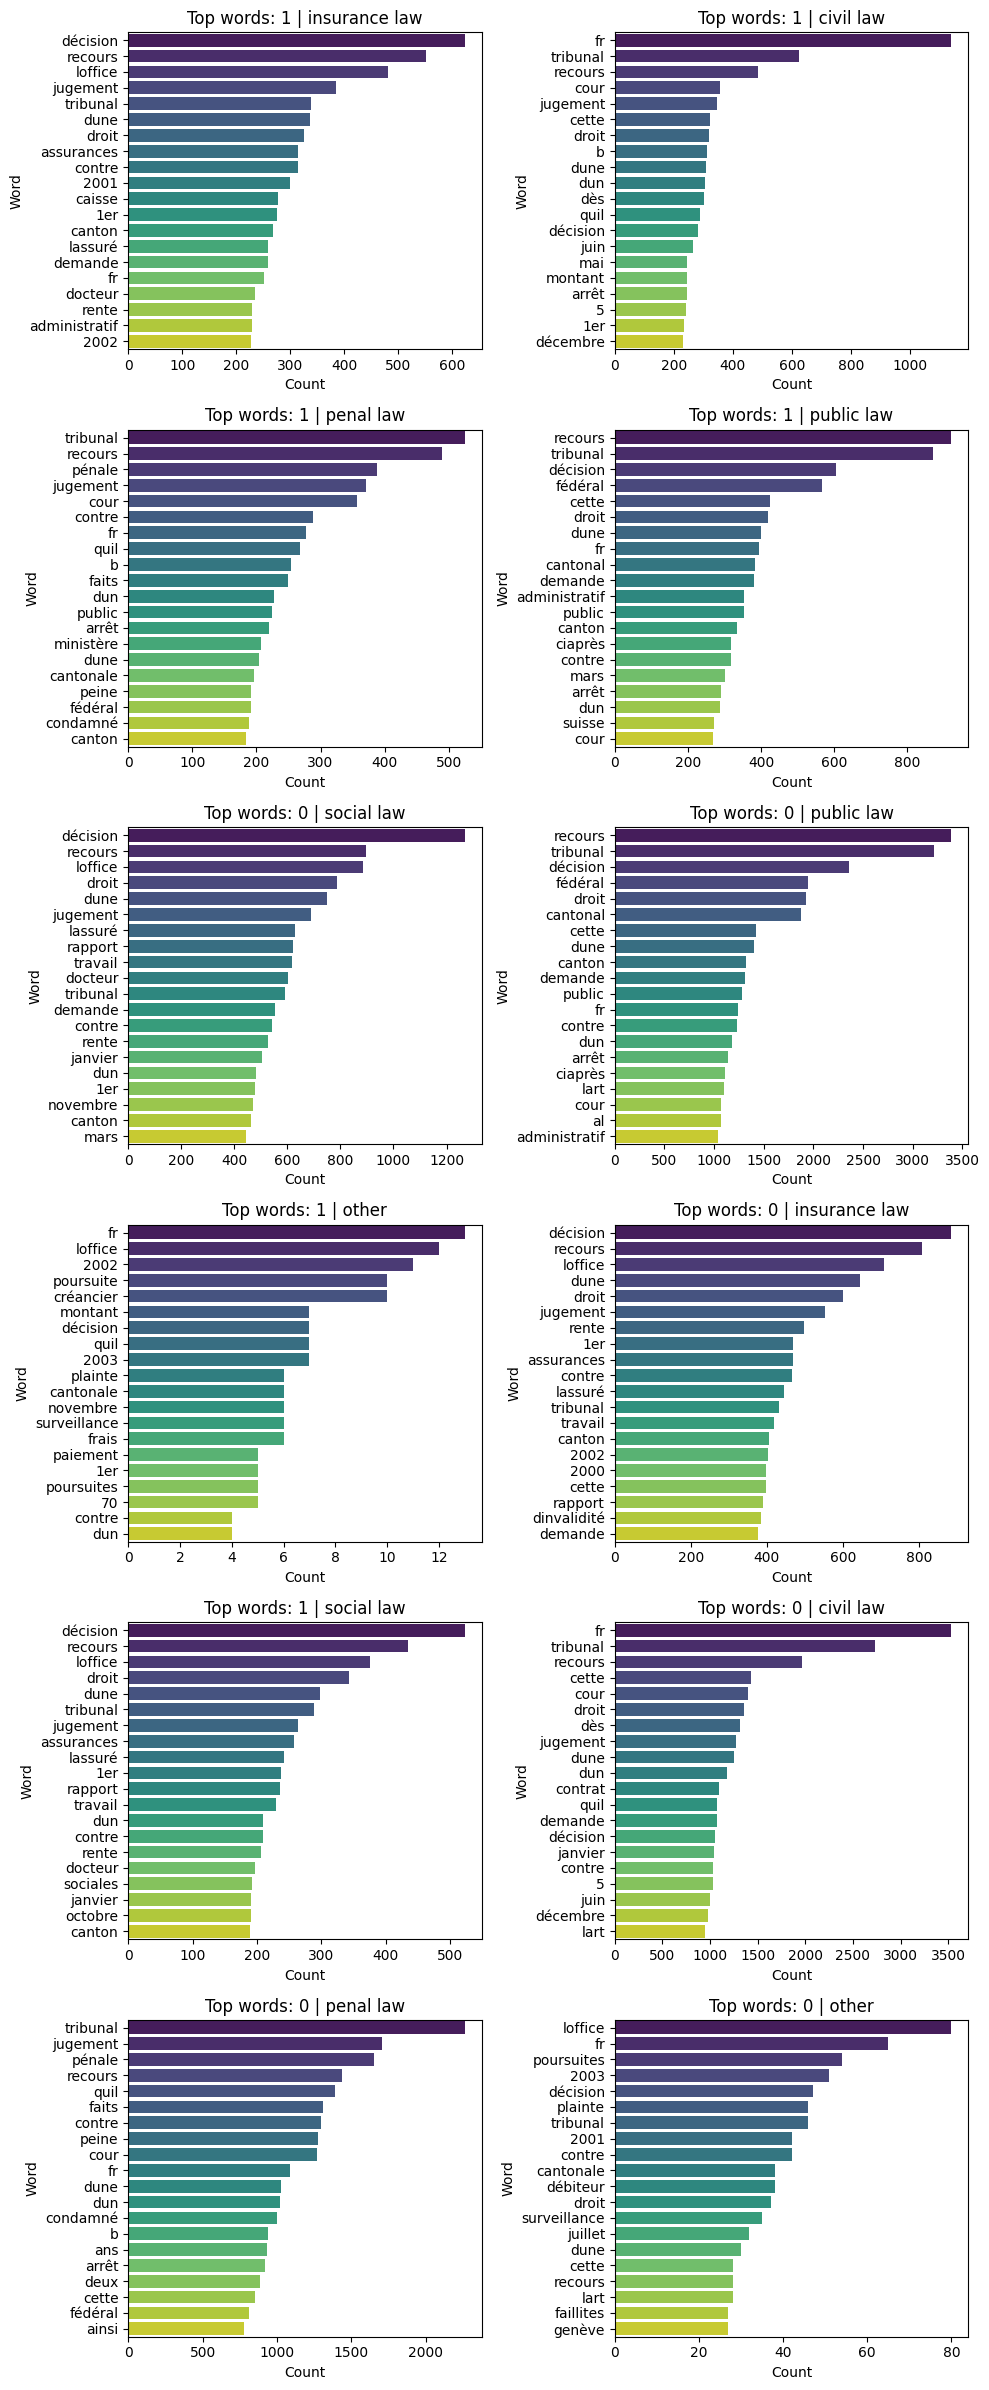

In [8]:
train_topwords_no_lem = get_top_words(train_df,
                                     text_column='clean_text_no_lem', 
                                     class_column='label',
                                     area_column='legal area',
                                     top_n=20)

plot_top_words(train_topwords_no_lem, 2)

### With lemmatization

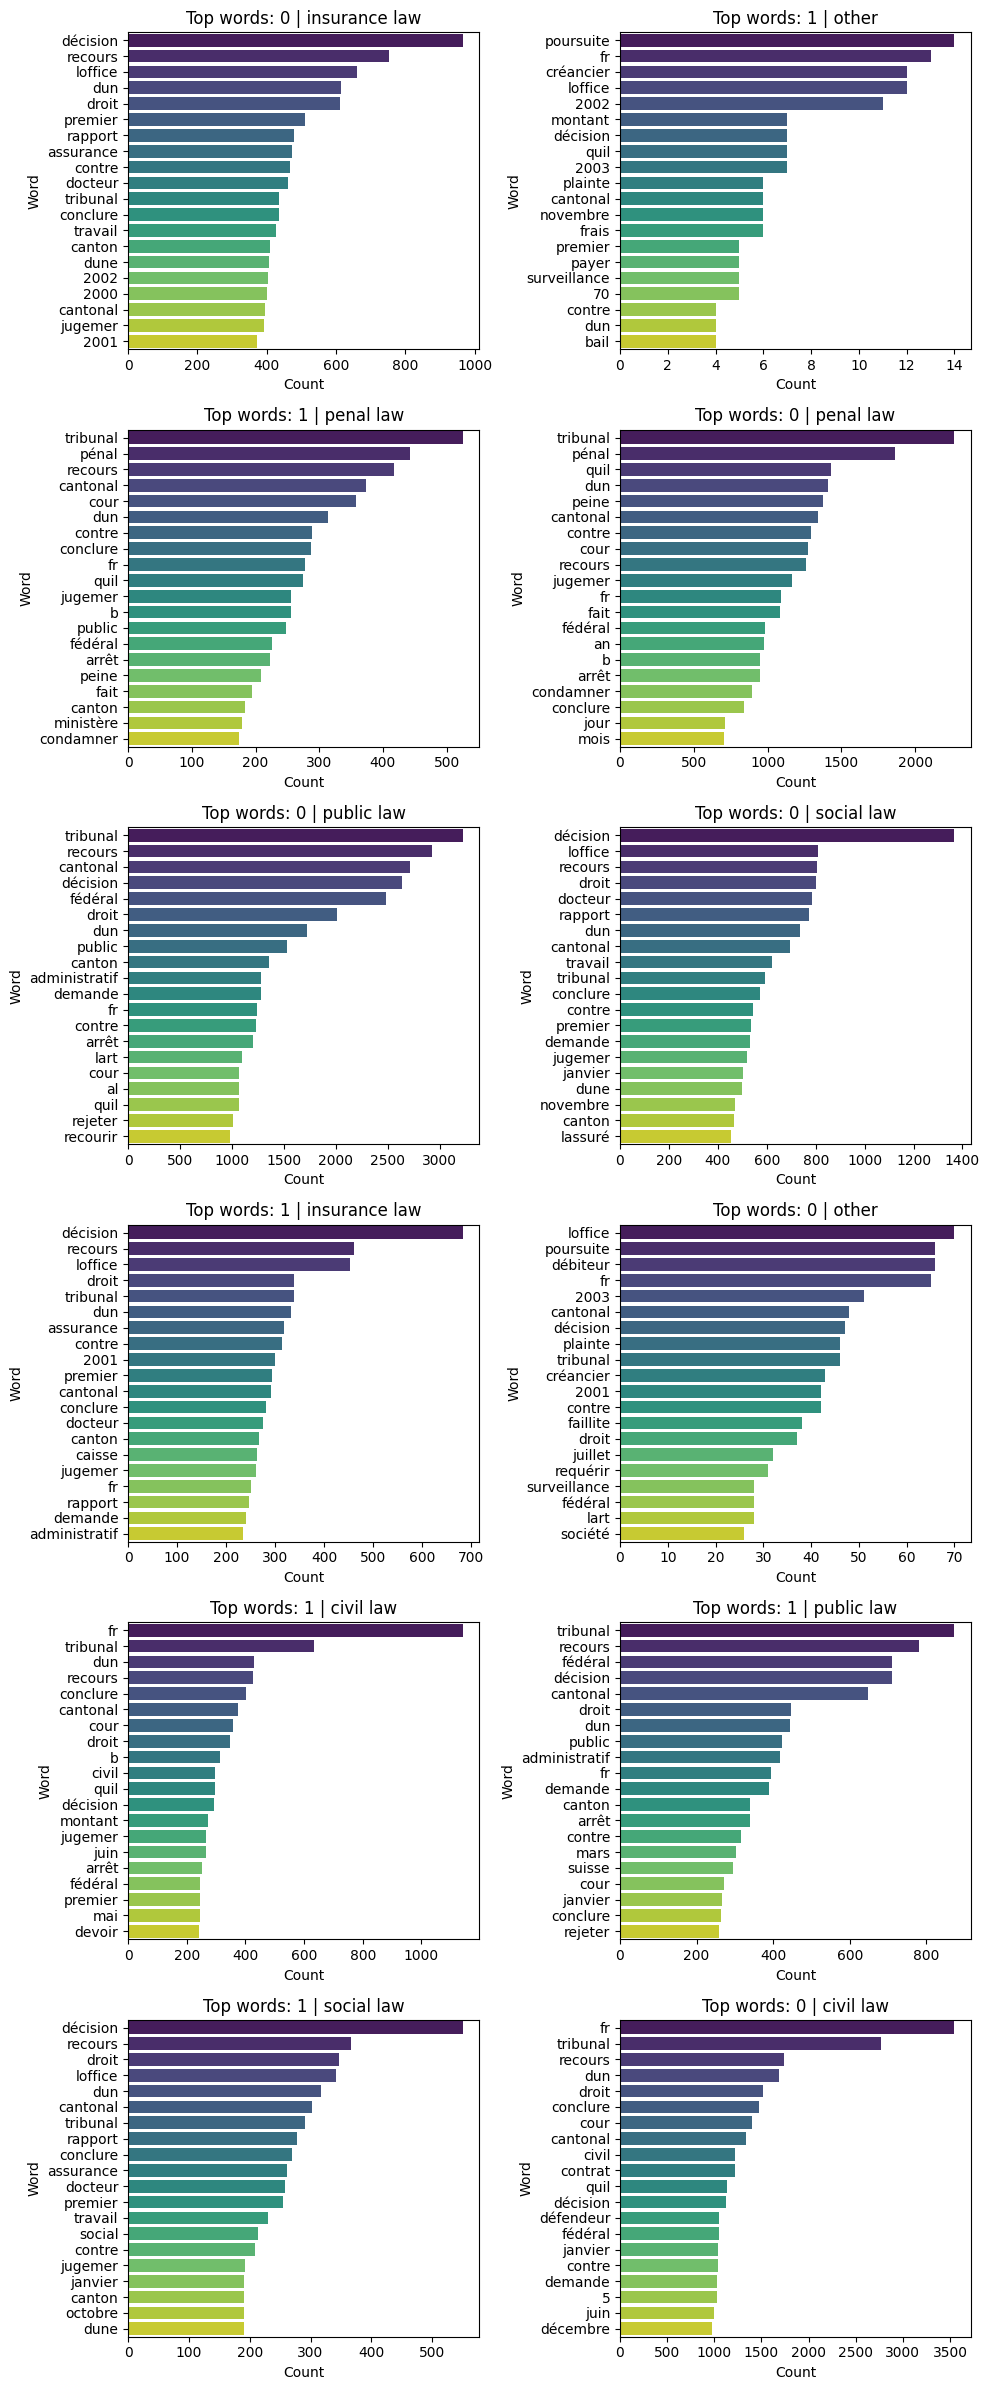

In [9]:
train_topwords_lem = get_top_words(train_df,
                                   text_column='clean_text_lem',
                                   class_column='label',
                                   area_column='legal area'
                                   )
plot_top_words(train_topwords_lem, 2)

## 1.4.2. Obtaining predictions + evaluating them

The way our predictor works is that it makes a prediction based on whether there is a higher count of words from the approval (label=1) or dismissal (label=0) dictionary for the respective legal area.

In [12]:
valid_df = clean_df(valid_df, lemmatize=False)
valid_df = clean_df(valid_df, lemmatize=True)

In [13]:
valid_df.write_parquet('data/valid_cleaned.parquet')
valid_df = pl.read_parquet('data/valid_cleaned.parquet')

In [14]:
help(regex_classifier_ext)

Help on function regex_classifier_ext in module library.regex_classifiers.regex_classifier_ext:

regex_classifier_ext(df, pred_column: str, text_column: str, topwords_dict: dict) -> polars.dataframe.frame.DataFrame
    Makes predictions based on the regex patterns.
    Predicts dismissal or approval according to the count of top words from the respective dictionary.

    Args:
        df (pl.DataFrame): DataFrame containing the text data.
        pred_column (str): Name of the column to store predictions.
        text_column (str): Name of the column containing the text to analyze.
        topwords_dict (dict): Dictionary with tuples as keys (label, legal area) and lists of top words as values.



In [15]:
valid_df = regex_classifier_ext(valid_df, 'regex_pred_no_lem', 'clean_text_no_lem', train_topwords_no_lem)
valid_df = regex_classifier_ext(valid_df, 'regex_pred_lem', 'clean_text_lem', train_topwords_lem)

valid_df.head()

id,year,text,label,language,region,canton,legal area,source_language,clean_text_no_lem,clean_text_lem,regex_pred_no_lem,regex_pred_lem
i64,i64,str,i64,str,str,str,str,str,list[str],list[str],i64,i64
14992,2008,"""Faits: A. G._ a requis l'octro…",0,"""fr""","""n/a""","""n/a""","""social law""","""n/a""","[""faits"", ""requis"", … ""déterminations""]","[""fait"", ""requérir"", … ""détermination""]",0,0
22910,2011,"""Faits: A. La Société X._, déte…",0,"""fr""","""Région lémanique""","""ge""","""social law""","""n/a""","[""faits"", ""société"", … ""déterminer""]","[""fait"", ""société"", … ""déterminer""]",1,1
17315,2009,"""Faits: A. G._ a bénéficié d'un…",0,"""fr""","""Région lémanique""","""ge""","""social law""","""n/a""","[""faits"", ""bénéficié"", … ""prononcer""]","[""fait"", ""bénéficier"", … ""prononcer""]",0,0
41014,2018,"""Faits : A. A._, né en 1989, tr…",0,"""fr""","""Espace Mittelland""","""be""","""social law""","""n/a""","[""faits"", ""né"", … ""déterminé""]","[""fait"", ""naître"", … ""déterminé""]",0,0
19111,2010,"""Faits: A. A.a Par jugement du …",0,"""fr""","""Espace Mittelland""","""ne""","""penal law""","""n/a""","[""faits"", ""aa"", … ""décritures""]","[""faire"", ""aa"", … ""décriture""]",0,1


Metrics calculated for: Rule-Based Classifier

Metrics for Rule-Based Classifier

Accuracy: 60.11%

Precision: 55.22%

Recall: 57.31%

F1 Score: 53.81%


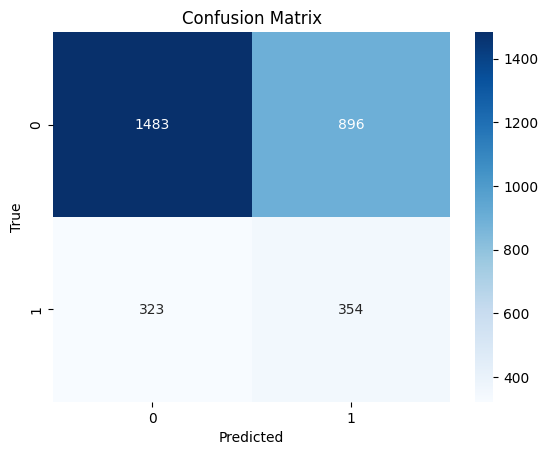

In [16]:
y_true_valid = valid_df['label'].to_list()
y_pred_valid = valid_df['regex_pred_no_lem'].to_list()

valid_metrics = Metrics()

valid_metrics.run(y_true_valid, y_pred_valid, 'Rule-Based Classifier')
valid_metrics.print_results()

valid_metrics.confusion_matrix(y_true_valid, y_pred_valid, 'Rule-Based Classifier')

In [17]:
# CHECKING PERFORMANCE PER LEGAL AREA
for area in valid_df['legal area'].unique().to_list():
    subset = valid_df.filter(pl.col('legal area') == area)
    y_true = subset['label'].to_list()
    y_pred = subset['regex_pred_no_lem'].to_list()

    print(f"\n---- {area.upper()} ----")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred, zero_division=0):.4f}")


---- CIVIL LAW ----
Accuracy: 0.5607
F1 Score: 0.3534

---- OTHER ----
Accuracy: 0.7778
F1 Score: 0.5000

---- PENAL LAW ----
Accuracy: 0.7014
F1 Score: 0.4108

---- SOCIAL LAW ----
Accuracy: 0.6132
F1 Score: 0.4143

---- PUBLIC LAW ----
Accuracy: 0.5505
F1 Score: 0.2967

---- INSURANCE LAW ----
Accuracy: 0.5331
F1 Score: 0.4174


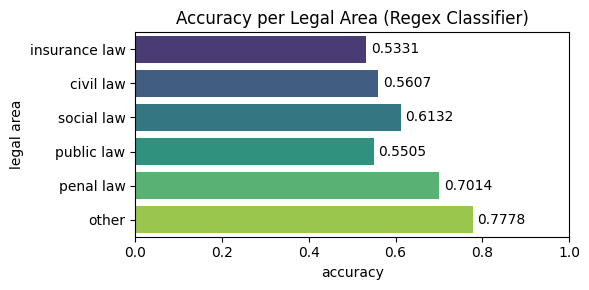

In [18]:
# PLOTTING ACCURACY PER LEGAL AREA
area_accuracies = []

for area in valid_df['legal area'].unique().to_list():
    subset = valid_df.filter(pl.col('legal area') == area)
    y_true = subset['label'].to_list()
    y_pred = subset['regex_pred_no_lem'].to_list()

    acc = round(accuracy_score(y_true, y_pred), 4)
    area_accuracies.append((area, acc))

areas, accuracies = zip(*area_accuracies)

df_acc = pd.DataFrame(area_accuracies, columns=["legal area", "accuracy"])

plt.figure(figsize=(6, 3))
sns.barplot(data=df_acc, x="accuracy", y="legal area", palette="viridis")

for i, row in df_acc.iterrows():
    plt.text(row["accuracy"] + 0.01, i, f'{row["accuracy"]:.4f}', va='center')

plt.title("Accuracy per Legal Area (Regex Classifier)")
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()


# 1.4.3. Hyperparameter tuning

The only two hyperparameters we have in this case are:
* Number of top words
* Lemmatization - whether we perform it or not

To see what is our best option, we will plot, for each lemmatization option, a curve of the accuracy against different values of top words.

This takes some time...
Accuracies calculated.


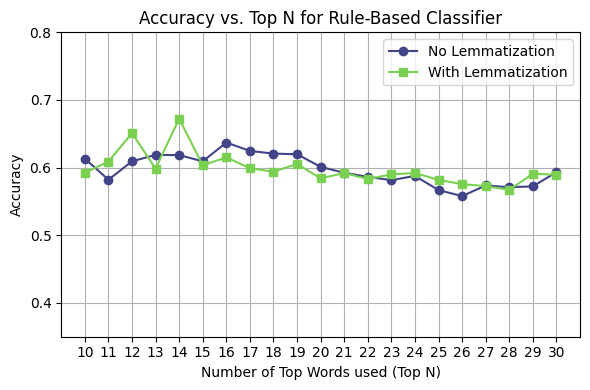

In [19]:
top_ns = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

plot_accuracies_curve(valid_df, train_df, top_ns)

Our best performing combination is using the **14 top words with lemmatization** (0.67 accuracy).

# 1.4.4. Applying to Test

In [22]:
test_df = clean_df(test_df, lemmatize=True)

topwords = get_top_words(train_df,
                         text_column='clean_text_lem',
                         class_column='label',
                         area_column='legal area',
                         top_n=14)

test_df = regex_classifier_ext(test_df, 'regex_pred_lem', 'clean_text_lem', topwords)

y_true_test = test_df['label'].to_list()
y_pred_test = test_df['regex_pred_no_lem'].to_list()

test_metrics = Metrics()

test_metrics.run(y_true_test, y_pred_test, 'Rule-Based Classifier')
test_metrics.print_results()

Metrics calculated for: Rule-Based Classifier

Metrics for Rule-Based Classifier

Accuracy: 62.23%

Precision: 56.77%

Recall: 58.97%

F1 Score: 56.08%


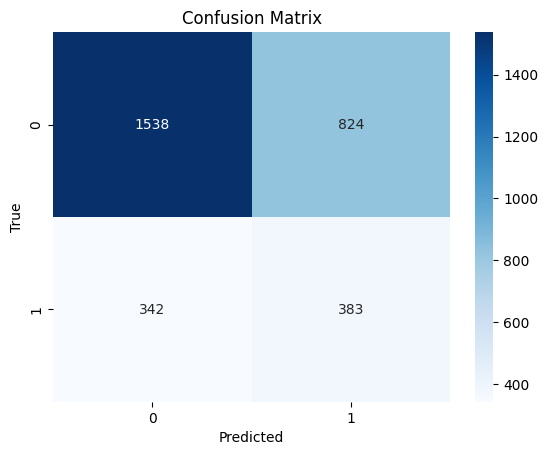

In [23]:
test_metrics.confusion_matrix(y_true_test, y_pred_test, 'Rule-Based Classifier')

Finally, we obtain 62% accuracy on the test set. While it's not amazing performance, it is quite good, given that we did not expect there to be any clear patterns in simply looking at separate words.